My goal here is to share the preprocessing of this data by extracting the raw scan information and then use the masks provided to extract specific areas.



In [ ]:
%matplotlib inline
import nibabel
import matplotlib.pyplot as plt
import numpy as np

# Loading data

Using [NiBabel](https://nipy.org/nibabel/) to load the data into memory.
Let's start with an example : the first data from coronacases.org dataset

In [ ]:
# Load image files with nibabel 
CT = nibabel.load('../input/covid19-ct-scans/ct_scans/coronacases_org_001.nii')

We need then to extract the data from it (separate from the large header and metadata).
The size of this data is (512,512,200).
We can interpret this as 200 slices of 512x512 images

In [ ]:
CT_array = CT.get_fdata()
CT_array.shape

To identify the axes and to which body dimension they correspond, let's plot a slice by fixing the first dimension to the middle plane.
For this, we can use matplotlib.imshow and notice that transposing the matrix makes an easier visualization

In [ ]:
CT_array = CT_array.T
plt.imshow(CT_array[200])

# Using the masks provided

Let's extract the data from one of the mask documents to understand how these different files fit each other.****

In [ ]:
mask = nibabel.load('../input/covid19-ct-scans/lung_mask/coronacases_001.nii')

left_mask_array = mask.get_fdata()
left_mask_array = left_mask_array.T
right_mask_array = left_mask_array.copy()

plt.imshow(left_mask_array[200])

The mask data is a segm!entation of the sections of interest.
It has the same size as the raw data but contains as follows :
 * 0 if we are not within a marked volume (shown in black on the previous picture)
 * 1 if we are in the volume labeled 1 (right lung shown in yellow)
 * 2 if we are in the volume labeled 2 (left lung shown in green)
 
 This here is a visualization from an external software showing this good segmentation in 3D
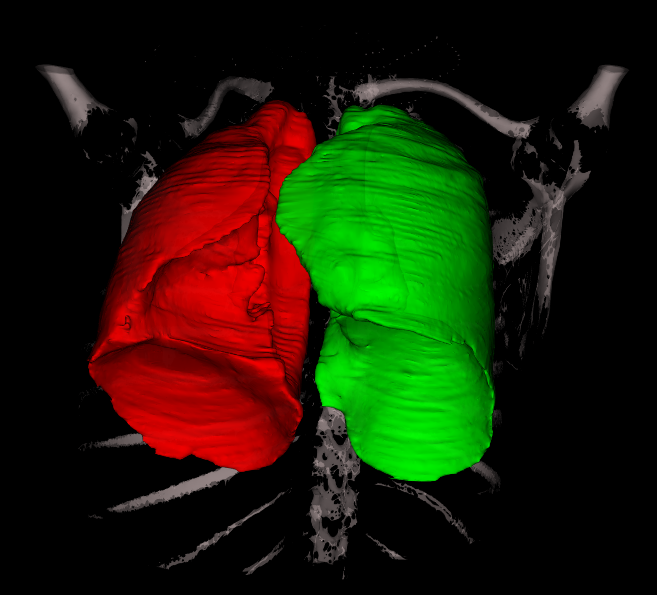

We can then separate this mask into 2 separate (one for each lung)
--> Then element-wise multiply the raw data by this mask to extract each individual lung and get rid of any raw data outside of this body (set to 0)

In [ ]:
left_mask_array[left_mask_array == 2] = 0
right_mask_array[right_mask_array == 1] = 0
right_mask_array = right_mask_array / 2

left_lung_array = np.multiply(CT_array, left_mask_array)
right_lung_array = np.multiply(CT_array, right_mask_array)

left_lung_array = left_lung_array - np.amin(left_lung_array)
left_lung_array = left_lung_array / np.amax(left_lung_array)

right_lung_array = right_lung_array - np.amin(right_lung_array)
right_lung_array = right_lung_array / np.amax(right_lung_array)

plt.imshow(left_lung_array[200], cmap='jet')

There is a lot of area lost full of zeros that will slow down all our future algorithms.

However, to crop the volume efficiently, we need to scan all layers and find the most protruding in each direction

In [ ]:
width = left_mask_array.shape[1]
height = left_mask_array.shape[2]

xmin = 0
xmax = width
ymin = 0
ymax = height

for i in range(round(width / 2)):
    if np.sum(left_mask_array[:,:i,:]) == 0: xmin = i
    if np.sum(left_mask_array[:,width - i:,:]) == 0: xmax = width - i
    if np.sum(left_mask_array[:,:,:i]) == 0: ymin = i
    if np.sum(left_mask_array[:,:,height - i:]) == 0: ymax = height - i
    
print(xmin, xmax, ymin, ymax)
left_lung_array = left_lung_array[:,xmin:xmax,ymin:ymax]

plt.imshow(left_lung_array[200], cmap='jet')

# What's next? :

We now have the lungs data extracted and separated left/right.
It is now a much smaller amount of data and is a good base for macgine learning exercises, have fun!


**
If this tutorial helped you at all, please upvote it and leave a comment :)**